In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import lib to clear the news
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
# import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed, concatenate
from keras.models import Model,Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [4]:
TXT_DATA_FILE = 'data2/news/news_GOOGL.csv'
NUM_DATA_FILE = 'data2/prices/stockPrices_GOOGL.csv'

In [5]:
# the number of words taken into consideration
MAX_FEATURES = 20000
# max lenght of one pieces of news
MAX_LEN = 30
# max number of news taken into consideration per day
MAX_NEWS_NUM = 30

In [6]:
txt_df = pd.read_csv(TXT_DATA_FILE)
txt_df['date'] = pd.to_datetime(txt_df['date'])
txt_df.sort_values('date',inplace=True)
txt_df = txt_df[txt_df['date'] < pd.Timestamp(2019,3,1)]
txt_df = txt_df[txt_df['date'] >= pd.Timestamp(2016,1,1)]
txt_df = txt_df.drop(['company'],axis=1)

In [7]:
num_df = pd.read_csv(NUM_DATA_FILE)
num_df['Date'] = pd.to_datetime(num_df['Date'])
num_df.sort_values('Date',inplace=True)

In [8]:
# divide data in to three groups: test development train
num_test = num_df[num_df['Date'] >= pd.Timestamp(2019,1,1)].values # test_set
tmp = num_df[num_df['Date'] < pd.Timestamp(2019,1,1)]
num_dev = tmp[tmp['Date'] >= pd.Timestamp(2018,9,1)].values # development_set
num_train = tmp[tmp['Date'] < pd.Timestamp(2018,9,1)].values # train_set
del tmp

In [9]:
print(txt_df.shape)
txt_df.head(10)

(4762, 3)


,code,date,text
1347,GOOGL,2016-01-04,Ford Toyota ally to counter Silicon Valley in...
1346,GOOGL,2016-01-04,GM invests $500 million in Lyft sets out self...
1345,GOOGL,2016-01-05,Ford will expand self-driving test car fleet t...
1344,GOOGL,2016-01-05,German publishers have filed complaint against...
1343,GOOGL,2016-01-05,Automakers not Silicon Valley lead in driver...
1361,GOOGL,2016-01-06,Automakers strike back at Silicon Valley disru...
1360,GOOGL,2016-01-06,Activist investor turns up heat on Yahoo seek...
1362,GOOGL,2016-01-06,Coca-Cola blames ad agency for map showing Cri...
1357,GOOGL,2016-01-07,Renault-Nissan alliance plans self-driving car...
1358,GOOGL,2016-01-07,Mobileye wants automakers to share maps for au...


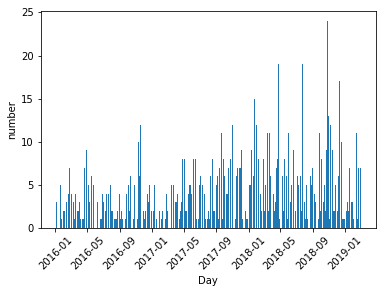

In [10]:
# count the number of news by date
# in order to check the dense of news
news_num_date = txt_df.groupby(txt_df['date']).count()
attribute =  'text'
plt.bar(news_num_date.index,news_num_date[attribute])
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('number')
plt.show()
del news_num_date

In [11]:
# clear news 
# remove non-word and lemmatize words
def _clean_text(text):
    lemma=WordNetLemmatizer()
    text=str(text)
    #text=re.sub('[^a-zA-Z\-\']', ' ',text)  # How to deal with 'NUMBER'?
    #text=[lemma.lemmatize(w) for w in word_tokenize(text)]
    text.replace('\'s','') #!
    text.replace('\'','') #!
    text=[lemma.lemmatize(w) for w in text.lower().split()]  # 词性还原
    text=' '.join(text)
    text=re.sub('[^a-zA-Z]', ' ' ,text) #!
    return text

def clean_news(df):
    text = df['text']
    text = _clean_text(text)
    return text

txt_df['text'] = txt_df.apply(clean_news, axis=1)

In [12]:
# change the dataframe into dict
# map: pd.Timestamp->news_group
def df_to_dict(df):
    news_group_dict = dict()
    for index, row in df.iterrows():
        if row['date'] not in news_group_dict:
            news_group_dict[row['date']] = list()
        news_group_dict[row['date']].append(row['text'])
    
    for key in news_group_dict:
        blank = MAX_NEWS_NUM - len(news_group_dict[key])
        if blank >= 0:
            # need some blank
            for _ in range(blank):
                news_group_dict[key].append('')
        else:
            # need delete some elements
            for _ in range(-blank):
                # best is 'random'
                news_group_dict[key].pop()    
    return news_group_dict

In [13]:
# divide data in to three groups: test development train
txt_test = df_to_dict(txt_df[txt_df['date'] >= pd.Timestamp(2019,1,1)]) # test_set
tmp = txt_df[txt_df['date'] < pd.Timestamp(2019,1,1)] # ---bound---
txt_dev = df_to_dict(tmp[tmp['date'] >= pd.Timestamp(2018,9,1)]) # development_set
txt_train = df_to_dict(tmp[tmp['date'] < pd.Timestamp(2018,9,1)]) # train_set
del tmp

In [14]:
# change text into sequences with Keras
tmp = txt_df[txt_df['date'] < pd.Timestamp(2019,1,1)]
tk_train = tmp[tmp['date'] < pd.Timestamp(2018,9,1)]
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(tk_train['text']))
del tmp,tk_train

def _text_to_sequences(alist):
    tokens = tokenizer.texts_to_sequences(alist)
    seqs = pad_sequences(tokens,maxlen=MAX_LEN,truncating='post')
    return seqs

def text_to_sequences_by_day(adict):
    # inplace
    for (date,text_list) in adict.items():
        adict[date] = _text_to_sequences(text_list)
    return adict

# overwrite
txt_dev = text_to_sequences_by_day(txt_dev)
txt_test = text_to_sequences_by_day(txt_test)
text_train = text_to_sequences_by_day(txt_train)

In [15]:
from data_util import get_xy_txt

In [16]:
(x_train, y_train) = get_xy_txt(txt_train,num_train)
(x_test, y_test) = get_xy_txt(txt_test,num_test)
(x_dev, y_dev) = get_xy_txt(txt_dev,num_dev)

# the baseline of word embedding
in the baseline, we just use the trained word vector matrix

In [ ]:
# use GloVe
EMB_FILE = "tool/GloVe/glove.42B.300d.txt"
#！can't use 840B
def get_coefs(word,*arr):
    return word,np.asarray(arr,dtype='float32')
emb_index = dict(get_coefs(*o.strip().split()) for o in open(EMB_FILE))

In [ ]:
emb_size=300
all_embs = np.stack(emb_index.values())
emb_mean = all_embs.mean()
emb_std = all_embs.std()
word_index = tokenizer.word_index
hit_rate = 0
ft_words = min(MAX_FEATURES,len(word_index))
emb_matrix = np.random.normal(emb_mean,emb_std,(ft_words+1,emb_size))
emb_matrix[0] = np.zeros(emb_size)  #！
for word, i in word_index.items():
    if i > ft_words:
        continue
    emb_vector = emb_index.get(word)
    if emb_vector is not None:
        hit_rate += 1
        emb_matrix[i] = emb_vector
hit_rate = hit_rate/ft_words
print('Hit Rate is: ', hit_rate)

In [ ]:
emb_model = Sequential()
emb_model.add(Embedding(ft_words+1, emb_size, weights=[emb_matrix],trainable=False,\
                        input_shape = (DATE_INTERVAL,MAX_NEWS_NUM,MAX_LEN)))
emb_model.compile('rmsprop', 'mse')

In [ ]:
x_dev = emb_model.predict(x_dev)
x_test = emb_model.predict(x_test)
x_train = emb_model.predict(x_train)

# the baseline of news embedding
in the baseline, we just add all word vectors in every news up

In [ ]:
def news_embedding_baseline(x_data):
    shape = x_data.shape
    shape_dim = len(shape)
    return np.mean(x_data,axis=shape_dim-2)

In [ ]:
x_test = news_embedding_baseline(x_test)
x_train = news_embedding_baseline(x_train)
x_dev = news_embedding_baseline(x_dev)

# the baseline of importance recognition
in th baseline, we just use RNN to get the representation of the news corpus 

In [ ]:
def build_baseline_model(code='Default'):
    news_input = Input(shape=(DATE_INTERVAL,MAX_NEWS_NUM,emb_size))
    day_layer = GRU(100, return_sequences=False)
    day_layer = TimeDistributed(day_layer)
    inv_layer = GRU(100, return_sequences=False)
    x = day_layer(news_input)
    x = inv_layer(x)
    x = Dense(2,activation='softmax')(x)
    model = Model(inputs=news_input,outputs=x)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
model = build_baseline_model()

In [ ]:
print(model.summary())

In [ ]:
model.fit(x=x_train,y=y_train,batch_size=16,epochs=40,verbose=1,validation_data=(x_dev,y_dev))